## Analyzing A/B Test Results

### Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. This project explores the results of an A/B test run by an e-commerce website. 

The objective of this notebook is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import the libraries we'll need.

In [101]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#You can set the seed to assure you get the same results as this notebook
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [102]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [103]:
# df.shape => (rows, columns)
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [104]:
unique_users = df.user_id.nunique()
unique_users

290584

d. The proportion of users converted.

In [105]:
p_converted = df.converted.sum() / unique_users
p_converted

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [106]:
control_new_page = df.query('group == "control" and landing_page == "new_page"')
treatment_old_page = df.query('group == "treatment" and landing_page == "old_page"')
mismatched = control_new_page.user_id.count() + treatment_old_page.user_id.count()
mismatched

3893

f. Do any of the rows have missing values?

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**No, each column has the complete 294,478 entries.**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. We'll deal with these rows, below.

a. Let's remove these invalid rows and store the new dataframe in **df2**.

In [108]:
control_old_page = df.query('group == "control" and landing_page == "old_page"')
treatment_new_page = df.query('group == "treatment" and landing_page == "new_page"')
df2 = control_old_page.append(treatment_new_page, ignore_index=True)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [109]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below for further exploration of the dataset.

a. How many unique **user_id**s are in **df2**?

In [110]:
unique_users = df2.user_id.nunique()
unique_users

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [111]:
duplicates = pd.DataFrame(df2.user_id.duplicated())
duplicates.head()

,user_id
0,False
1,False
2,False
3,False
4,False


In [112]:
duplicated_index = duplicates.query('user_id == True')
duplicated_index = duplicated_index.index[0]

In [113]:
duplicated_id = df2['user_id'][duplicated_index]
duplicated_id

773192

c. What is the row information for the repeat **user_id**? 

In [114]:
duplicated_user = df2.query('user_id == @duplicated_id')
duplicated_user

,user_id,timestamp,group,landing_page,converted
146212,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
146678,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [115]:
drop_index = duplicated_user.index[0]
df2.drop(index=drop_index, inplace=True)

# check that one entry still remains
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
146678,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the cells below to explore the probability within the data.

a. What is the probability of an individual converting regardless of the page they receive?

In [116]:
p_converted = (df2.converted == 1).mean()
p_converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [117]:
df_control = df2.query('group == "control"')
p_converted_given_control = (df_control.converted == 1).mean()
p_converted_given_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [118]:
df_treatment = df2.query('group == "treatment"')
p_converted_given_treatment = (df_treatment.converted == 1).mean()
p_converted_given_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [119]:
p_new_page = (df2.landing_page == "new_page").mean()
p_new_page

0.50006194422266881

e. Considering the results from parts (a) through (d) above, is there sufficient evidence to conclude that the new treatment page leads to more conversions? 

In [120]:
sample_diff = (p_converted_given_treatment - p_converted_given_control)
sample_diff

-0.0015782389853555567

**A user is 15.78% less likely to be converted on a new page than an old page.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, then the following is the null hypothesis:   

**$$H_o: p_{old} \geq p_{new}$$** 
**$$H_a: p_{old} < p_{new}$$** 


$$\alpha = 0.05$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page , `p_converted`. <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [121]:
p_new = p_converted
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [122]:
p_old = p_converted
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [123]:
n_new = df2.query('group == "treatment"').user_id.count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [124]:
n_old = df2.query('group == "control"').user_id.count()
n_old

145274

In [125]:
n_old + n_new == df2.user_id.count()

True

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [126]:
def sampleNew():
    new_page_converted = np.random.choice([0,1], p=[1-p_new, p_new], size=n_new)
    new_page_converted = new_page_converted.mean()
    return new_page_converted

new_page_converted = sampleNew()
new_page_converted

0.11935173078246507

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [127]:
def sampleOld():
    old_page_converted = np.random.choice([0,1], p=[1-p_old, p_old], size=n_old)
    old_page_converted = old_page_converted.mean()
    return old_page_converted

old_page_converted = sampleOld()
old_page_converted

0.11923675261918856

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [128]:
diff = new_page_converted - old_page_converted
diff

0.00011497816327650512

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [129]:
p_diffs = []
for _ in range(10000): 
    diff = sampleNew() - sampleOld()
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  

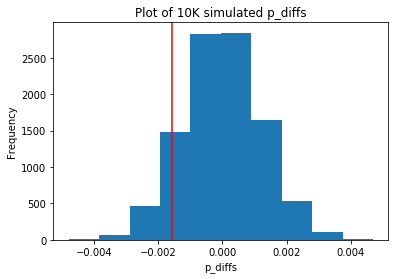

In [130]:
plt.hist(p_diffs);
plt.axvline(sample_diff, color='red');
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot of 10K simulated p_diffs');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [131]:
p_val = (p_diffs > sample_diff).mean()
p_val

0.9042

k. Interpretation (Explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?)

**The above value represents the p-value of the hypothesis test, or the probability of getting our sample value or higher assuming our null hypothesis is true. In this case, we have that chance of getting our sample value if our null hypothesis were true; therefore, the results are probably due to chance and we fail to reject the alternative hypothesis that the new page is better than the old.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [132]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [133]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [134]:

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score tells us how many standard deviations from the null mean we are, and the p-value tells us the probability of getting this value or more extreme if the null is true.** 

**In this case, the z-score means we are 1.31 standard deviations from the mean. Since the p-value is 0.905 and is greater than our alpha of 0.05, we can conclude that we should fail to reject the null hypothesis: the new landing page does not get better conversion rates than the old.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We will use logistic regression for predicting a categorical, yes/no, variable.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [135]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [136]:
df2['intercept'] = 1

In [137]:
df2[['ab_page', 'drop_ab_page']] = pd.get_dummies(df2['landing_page'])
df2.drop(columns=['drop_ab_page'], inplace=True)

# check that we've added the intercept and dummy variable
df2.query('landing_page == "new_page"').head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
145274,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
145275,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
145276,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
145277,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
145278,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [138]:
logit_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

In [139]:
results = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [140]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-02-27 21:32 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

***ab_page p-value = 0.1899.***

***In Part II, the p-value was 0.9051.***

**The reason for the difference in p-values is that Part II tested whether the probability of conversion was different on the new page vs. the old page. I.e. The conversion rate is the same or better for the old page than the new page.**

**Here, in Part II, this p-value is looking at whether ab_page is a good predictor for conversions. I.e. the type of page (old vs. new) is not a good predictor of conversions.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Advantages of adding other factors to the regression model:** By adding new factors, we would be more likely to find the true factors that influence the conversion rate. Right now, we are only looking at one factor - page type - so we might be missing other things that affect conversion rate.

**Disadvantages of adding other factors to the regression model:** By adding new factors, we are introducting more opportunities for multicollinearity where two independent variables are correlated. Multicollinearity can result in changing the sign and magnitude of the coefficients and mask their individual importance. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

In [141]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [142]:
# add countries to our AB testing dataset
df_new = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [143]:
# create dummy variables for country
df_new[['US', 'UK']] = pd.get_dummies(df_new['country'])[['US', 'UK']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [144]:
# create and fit the model with all variables
log_mod_2 = sm.Logit(df_new['converted'],df_new[['intercept', 'ab_page', 'US', 'UK']])
results_2 = log_mod_2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [145]:
# run the results
results_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-02-27 21:32 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

In [146]:
# create a model for just the country variables

log_mod_3 = sm.Logit(df_new['converted'],df_new[['US', 'UK']])
results_3 = log_mod_3.fit()
results_3.summary2()

Optimization terminated successfully.
         Current function value: 0.382864
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: -0.046     
Date:               2020-02-27 21:32 AIC:              222512.1606
No. Observations:   290584           BIC:              222533.3199
Df Model:           1                Log-Likelihood:   -1.1125e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
--------------------------------------------------------------------
          Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
US       -1.9967     0.0068   -292.3145   0.0000   -2.0101   -1.9833
UK       -1.9868     0.0114   -174.1736   0.0000   -2.0092   -1.9645
==================================================================

"""

**When we run a model that predicts conversion rate with only the country dummy variables, country becomes a statistically significant predictor.**

**Caveat:** The above model does not use the intercept as a predictor variable.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [147]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [148]:
# create interaction terms for ab_page x US and ab_page x UK
df_new['ab_page_us'] = df_new['ab_page'] * df_new['US']
df_new['ab_page_uk'] = df_new['ab_page'] * df_new['UK']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,ab_page_us,ab_page_uk
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


In [149]:
# build a model which uses intercept, ab_page, US, UK, ab_page_us, and ab_page_uk
log_mod_4 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK', 'ab_page_us', 'ab_page_uk']])
results_4 = log_mod_4.fit()
results_4.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-02-27 21:32 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
ab_page_us     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
ab_page_uk     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

**In the model with all six factors, none of the factors appear significant as predictors. Non of their p-values is below 0.05.**

In [150]:
# build a model which uses only the interaction terms
log_mod_5 = sm.Logit(df_new['converted'], df_new[['ab_page_us', 'ab_page_uk']])
results_5 = log_mod_5.fit()
results_5.summary2()

Optimization terminated successfully.
         Current function value: 0.537425
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: -0.468     
Date:               2020-02-27 21:32 AIC:              312338.4236
No. Observations:   290584           BIC:              312359.5829
Df Model:           1                Log-Likelihood:   -1.5617e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page_us   -2.0070    0.0097  -207.0454  0.0000  -2.0260  -1.9880
ab_page_uk   -1.9814    0.0161  -122.8600  0.0000  -2.0130  -1.9498
==================================================================

"""

**In the model the predicts conversion rate with only the interaction terms of** *ab_page X US* **and** *ab_page X UK* **, both predictors are significant with p-values less than 0.05.**

**Caveat:** The above model does not use the intercept as a predictor variable. 

In [151]:
# down

from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0